## Introduction
Motor vehicle crashes remain a significant public safety concern in many cities across the globe. Understanding the underlying causes of traffic accidents is essential for improving road safety, optimizing traffic regulations, and informing policy decisions. With the increasing availability of open data, machine learning offers powerful tools for discovering patterns and predicting outcomes that can lead to actionable insights.

This project uses publicly available crash, vehicle, and people datasets from the City of Chicago to develop a predictive model. The goal is to analyze a wide range of factors — including vehicle information, road conditions, and driver characteristics — to identify the primary contributory cause of each accident. By modeling this problem, we aim to support traffic safety stakeholders in better understanding crash dynamics and designing targeted interventions.

## Business Understanding
Motor vehicle accidents remain a persistent and costly public safety issue in urban centers. Every year, thousands of traffic accidents result in injuries, fatalities, and significant economic losses. Understanding the primary contributory causes of these crashes can help policymakers, urban planners, and safety boards implement targeted interventions to reduce accidents.

#### Objectives
Build a model that can predict the primary contributory cause of a car accident, given information about the car, the people in the car, the road conditions etc.

#### Key Questions
1. What are the most significant factors contributing to vehicle crashes in Chicago?
2. How do weather and lighting conditions impact accident causation patterns?
3. How do driver demographics (age, gender) correlate with accident causes?



## Data Understanding
This project uses three datasets published by City of Chicago (https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if)

* Traffic Crashes-Crashes Data: Shows information about each traffic crash on city streets within the City of Chicago
* Traffic Crashes-Driver/Passenger Data: Contains information about people involved in a crash and if any injuries were sustained
* Traffic Crashes- Vehicle Data: Contains information about vehicles involved in a traffic crash

##### Import the packages

In [6]:
#Import the necessary packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

%matplotlib inline


##### Load the Datasets

In [7]:
# Load crashes dataset
crashes_df=pd.read_csv('.\DATA\Crashes.csv', low_memory=False)
crashes_df.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,01184614b08579d6befa7734427e750d0f10e79dc0aa42...,NaN,04/04/2025 01:57:00 AM,15,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,PARKING LOT,...,0.0,0.0,2.0,0.0,1,6,4,41.766021,-87.572442,POINT (-87.572442196614 41.766020695126)
1,01db2b5a81860ebd2fa3f4564ba0de00508847313ce23a...,NaN,04/24/2025 08:40:00 PM,10,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO SIDE,PARKING LOT,...,0.0,0.0,2.0,0.0,20,5,4,41.875048,-87.744921,POINT (-87.744921303711 41.875047815678)
2,0583b2385710470c0a1bc80417d095512e3d04d6f26158...,NaN,04/24/2025 05:45:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAWN,TURNING,NOT DIVIDED,...,0.0,0.0,2.0,0.0,5,5,4,41.981238,-87.806997,POINT (-87.806997368434 41.981238161467)
3,05d78a76ea643730a5771ac904b43c56236f332b42db0e...,NaN,04/24/2025 11:13:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,ALLEY,...,0.0,1.0,0.0,0.0,11,5,4,41.742295,-87.652157,POINT (-87.652156998855 41.742294907932)
4,00a530520c84927490b597a6220ff3f2a3347472ef3086...,NaN,01/15/2025 01:50:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,RAMP,...,0.0,0.0,1.0,0.0,13,4,1,41.816073,-87.656743,POINT (-87.656742699936 41.816073475493)


In [8]:
# Load Vehicle dataset
Vehicle_df=pd.read_csv('.\DATA\Vehicles.csv', low_memory=False)
Vehicle_df.head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,...,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,10,2e31858c0e411f0bdcb337fb7c415aa93763cf2f23e02f...,08/04/2015 12:40:00 PM,1,DRIVER,NaN,10.0,NaN,FORD,Focus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100,e73b35bd7651b0c6693162bee0666db159b28901437009...,07/31/2015 05:50:00 PM,1,DRIVER,NaN,96.0,NaN,NISSAN,Pathfinder,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000,f2b1adeb85a15112e4fb7db74bff440d6ca53ff7a21e10...,09/02/2015 11:45:00 AM,1,DRIVER,NaN,954.0,NaN,FORD,F150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000,15a3e24fce3ce7cd2b02d44013d1a93ff2fbdca80632ec...,10/31/2015 09:30:00 PM,2,DRIVER,NaN,9561.0,NaN,HYUNDAI,SONATA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100000,1d3c178880366c77deaf06b8c3198429112a1c8e8807ed...,11/16/2016 01:00:00 PM,2,PARKED,NaN,96745.0,NaN,"TOYOTA MOTOR COMPANY, LTD.",RAV4 (sport utility),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Load People dataset
People_df=pd.read_csv('.\DATA\People.csv', low_memory=False)
People_df.head()

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,VEHICLE_ID,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,...,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,O749947,DRIVER,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O871921,DRIVER,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,827212.0,04/13/2020 10:50:00 PM,NaN,CHICAGO,IL,60620,M,...,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,O10018,DRIVER,71162af7bf22799b776547132ebf134b5b438dcf3dac6b...,9579.0,11/01/2015 05:00:00 AM,NaN,NaN,NaN,NaN,X,...,NaN,IMPROPER BACKING,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
3,O10038,DRIVER,c21c476e2ccc41af550b5d858d22aaac4ffc88745a1700...,9598.0,11/01/2015 08:00:00 AM,NaN,NaN,NaN,NaN,X,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O10039,DRIVER,eb390a4c8e114c69488f5fb8a097fe629f5a92fd528cf4...,9600.0,11/01/2015 10:15:00 AM,NaN,NaN,NaN,NaN,X,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


The datasets were merged using an inner join. This ensured that only records in all datasets were kept

In [10]:
# Merge the datasets
people_vehicle_df=pd.merge(People_df,Vehicle_df, how='inner', on='CRASH_RECORD_ID')

data_df=pd.merge(crashes_df, people_vehicle_df,  how='inner', on='CRASH_RECORD_ID')

data_df.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,01184614b08579d6befa7734427e750d0f10e79dc0aa42...,NaN,04/04/2025 01:57:00 AM,15,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,PARKING LOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01184614b08579d6befa7734427e750d0f10e79dc0aa42...,NaN,04/04/2025 01:57:00 AM,15,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,PARKING LOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01184614b08579d6befa7734427e750d0f10e79dc0aa42...,NaN,04/04/2025 01:57:00 AM,15,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,PARKING LOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01184614b08579d6befa7734427e750d0f10e79dc0aa42...,NaN,04/04/2025 01:57:00 AM,15,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",ANGLE,PARKING LOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01db2b5a81860ebd2fa3f4564ba0de00508847313ce23a...,NaN,04/24/2025 08:40:00 PM,10,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,REAR TO SIDE,PARKING LOT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory Data Analysis

In [11]:
# Take a sample of the data
sample_df = data_df.sample(frac=0.2, random_state=42)
sample_df

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
2248287,78931665a70e8e028b26a198efc20ae6817d48c33b910c...,NaN,06/13/2021 04:38:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,SIDESWIPE SAME DIRECTION,DIVIDED - W/MEDIAN BARRIER,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3831066,dc425e3d122cda62a23e44c065d08d44343f9712b2a192...,NaN,12/30/2022 06:36:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,NOT DIVIDED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3401644,c1470f194c6b9c58d2b3a09a40bfdd4bfd045eb1f9e181...,NaN,03/11/2019 08:30:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,NOT DIVIDED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2448962,85421e2f2b1a25d6969ed1da44cffd063849905ed41f17...,Y,02/16/2021 11:45:00 AM,30,NO CONTROLS,NO CONTROLS,SNOW,DAYLIGHT,PARKED MOTOR VEHICLE,ONE-WAY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2198053,755c1eef4171d786d59c75b9243a20fbd384da653aeb49...,NaN,08/22/2020 02:50:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,NOT DIVIDED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572106,8d035fb7050005a5c4070bb319388a5b63f4a8b1eeeb34...,NaN,11/01/2019 06:15:00 PM,15,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",FIXED OBJECT,ALLEY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887516,23268c55a6929776a786f6f3460224d56be0086631fc38...,NaN,06/17/2018 12:30:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,ONE-WAY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1211511,3792a9bd8e4514aa66d5b4820d19eab6d5cd3a1315f775...,NaN,07/26/2018 09:45:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN (NOT RAISED),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
780493,1c6d38c9d9eee18456d9f8c0f1c1f70d5636926fdf175f...,NaN,05/22/2020 07:00:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Make a copy of the data
sample_df=sample_df.copy()

In [13]:
# Select columns to use
cols_to_keep = [
        'CRASH_DATE', 'POSTED_SPEED_LIMIT', 'WEATHER_CONDITION',
        'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND', 'CRASH_TYPE',
        'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 'SEX', 'AGE', 'INJURIES_TOTAL',
        'VEHICLE_TYPE', 'MAKE', 'MODEL', 'VEHICLE_YEAR'
    ]
    
data_df = sample_df[cols_to_keep]

In [14]:
# Check shape of the data
data_df.shape

(880568, 15)

In [15]:
# Dataset information
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 880568 entries, 2248287 to 1715800
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_DATE               880568 non-null  object 
 1   POSTED_SPEED_LIMIT       880568 non-null  int64  
 2   WEATHER_CONDITION        880568 non-null  object 
 3   LIGHTING_CONDITION       880568 non-null  object 
 4   ROADWAY_SURFACE_COND     880568 non-null  object 
 5   CRASH_TYPE               880568 non-null  object 
 6   DAMAGE                   880568 non-null  object 
 7   PRIM_CONTRIBUTORY_CAUSE  880568 non-null  object 
 8   SEX                      865674 non-null  object 
 9   AGE                      627363 non-null  float64
 10  INJURIES_TOTAL           880568 non-null  float64
 11  VEHICLE_TYPE             859513 non-null  object 
 12  MAKE                     859509 non-null  object 
 13  MODEL                    859436 non-null  object 
 1

In [16]:
#Descriptive statistics
data_df.describe()

,POSTED_SPEED_LIMIT,AGE,INJURIES_TOTAL,VEHICLE_YEAR
count,880568.000000,627363.000000,880568.000000,744902.000000
mean,28.948832,37.806186,0.322325,2013.994885
std,5.569465,17.065108,0.864101,121.830718
min,0.000000,-177.000000,0.000000,1900.000000
25%,30.000000,25.000000,0.000000,2007.000000
50%,30.000000,35.000000,0.000000,2013.000000
75%,30.000000,50.000000,0.000000,2017.000000
max,99.000000,110.000000,21.000000,9999.000000


##### Missing Values

Missing values were identified within the dataset. For numeric columns, imputation was performed using the median due to its robustness against extreme outliers, ensuring a more stable and representative substitution

In [17]:
# Check for missing values
data_df.isna().sum().sort_values(ascending=False)

AGE                        253205
VEHICLE_YEAR               135666
MODEL                       21132
MAKE                        21059
VEHICLE_TYPE                21055
SEX                         14894
INJURIES_TOTAL                  0
PRIM_CONTRIBUTORY_CAUSE         0
DAMAGE                          0
CRASH_TYPE                      0
ROADWAY_SURFACE_COND            0
LIGHTING_CONDITION              0
WEATHER_CONDITION               0
POSTED_SPEED_LIMIT              0
CRASH_DATE                      0
dtype: int64

In [18]:
# Fill the missing values with median(Numeric columns)
data_df['AGE'].fillna(data_df['AGE'].median(), inplace=True)
data_df['VEHICLE_YEAR'].fillna(data_df['VEHICLE_YEAR'].median(), inplace=True)

# Categorical columns
cat_cols = data_df.select_dtypes(include='object').columns.tolist()

# Fill in missing values with the most frequent value
for col in cat_cols:
    if data_df[col].isnull().any():  
        most_frequent = data_df[col].mode(dropna=True)[0] 
        data_df[col].fillna(most_frequent, inplace=True)

##### Duplicates

Duplicated rows were identified and dropped.

In [19]:
# check for duplicates
data_df.duplicated().sum()

15097

In [20]:
# Remove duplicates
data_df.drop_duplicates(inplace=True)

The number of unique values per column was analyzed to detect high-cardinality categorical variables. Such features can degrade logistic regression performance when one-hot encoded, as they introduce excessive sparse dimensions and risk overfitting

In [21]:
# Check for the number of unique values in each column
for col in cat_cols:
    print(f"{col}: {data_df[col].nunique()} unique values")

CRASH_DATE: 424450 unique values
WEATHER_CONDITION: 12 unique values
LIGHTING_CONDITION: 6 unique values
ROADWAY_SURFACE_COND: 7 unique values
CRASH_TYPE: 2 unique values
DAMAGE: 3 unique values
PRIM_CONTRIBUTORY_CAUSE: 40 unique values
SEX: 3 unique values
VEHICLE_TYPE: 22 unique values
MAKE: 945 unique values
MODEL: 2255 unique values


In [22]:
# Convert categoricals with too many categories to 'OTHER'
for col in ['MAKE', 'MODEL', 'VEHICLE_TYPE']:
        top_values = data_df[col].value_counts().nlargest(10).index
        data_df[col] = data_df[col].where(data_df[col].isin(top_values), 'OTHER')
    
data_df

,CRASH_DATE,POSTED_SPEED_LIMIT,WEATHER_CONDITION,LIGHTING_CONDITION,ROADWAY_SURFACE_COND,CRASH_TYPE,DAMAGE,PRIM_CONTRIBUTORY_CAUSE,SEX,AGE,INJURIES_TOTAL,VEHICLE_TYPE,MAKE,MODEL,VEHICLE_YEAR
2248287,06/13/2021 04:38:00 AM,30,CLEAR,DUSK,DRY,NO INJURY / DRIVE AWAY,"OVER $1,500",IMPROPER OVERTAKING/PASSING,F,27.0,0.0,PASSENGER,FORD,OTHER,2014.0
3831066,12/30/2022 06:36:00 PM,30,CLEAR,"DARKNESS, LIGHTED ROAD",WET,NO INJURY / DRIVE AWAY,"OVER $1,500",UNABLE TO DETERMINE,F,58.0,0.0,PASSENGER,NISSAN,ROGUE,2020.0
3401644,03/11/2019 08:30:00 AM,30,CLEAR,DAYLIGHT,DRY,NO INJURY / DRIVE AWAY,"$501 - $1,500",FOLLOWING TOO CLOSELY,F,63.0,0.0,PASSENGER,HONDA,ACCORD,2007.0
2448962,02/16/2021 11:45:00 AM,30,SNOW,DAYLIGHT,SNOW OR SLUSH,NO INJURY / DRIVE AWAY,"OVER $1,500",WEATHER,X,35.0,0.0,UNKNOWN/NA,UNKNOWN,OTHER,2013.0
2198053,08/22/2020 02:50:00 PM,30,CLEAR,DAYLIGHT,DRY,NO INJURY / DRIVE AWAY,"$501 - $1,500",UNABLE TO DETERMINE,F,17.0,0.0,PASSENGER,OTHER,OTHER (EXPLAIN IN NARRATIVE),2003.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572106,11/01/2019 06:15:00 PM,15,CLEAR,"DARKNESS, LIGHTED ROAD",UNKNOWN,NO INJURY / DRIVE AWAY,$500 OR LESS,"OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",M,18.0,0.0,PASSENGER,NISSAN,OTHER,2014.0
887516,06/17/2018 12:30:00 PM,30,CLEAR,DAYLIGHT,DRY,NO INJURY / DRIVE AWAY,"$501 - $1,500",IMPROPER LANE USAGE,M,20.0,0.0,VAN/MINI-VAN,FORD,UNKNOWN,2016.0
1211511,07/26/2018 09:45:00 PM,30,CLEAR,"DARKNESS, LIGHTED ROAD",DRY,NO INJURY / DRIVE AWAY,"OVER $1,500",FOLLOWING TOO CLOSELY,F,42.0,0.0,PASSENGER,HYUNDAI,OTHER,2006.0
780493,05/22/2020 07:00:00 PM,30,CLEAR,DAYLIGHT,DRY,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500","OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",X,35.0,1.0,PASSENGER,UNKNOWN,OTHER (EXPLAIN IN NARRATIVE),2013.0


##### What are the most significant factors contributing to vehicle crashes in Chicago?

In [23]:
# Select the 5 most common causes
top_causes = data_df['PRIM_CONTRIBUTORY_CAUSE'].value_counts().nlargest(5).index
top_causes

Index(['UNABLE TO DETERMINE', 'FAILING TO YIELD RIGHT-OF-WAY',
       'FOLLOWING TOO CLOSELY', 'IMPROPER OVERTAKING/PASSING',
       'FAILING TO REDUCE SPEED TO AVOID CRASH'],
      dtype='object')

The most frequent contributory cause was 'Unable to determine,' but this category was excluded from the analysis due to its lack of actionable insight.

In [24]:
# Remove rows with vague/non-actionable contributory causes to improve data quality
data_df = data_df[~data_df['PRIM_CONTRIBUTORY_CAUSE'].isin([
    'UNABLE TO DETERMINE',  # Excluded due to ambiguity
    'NOT APPLICABLE'        # Excluded as it provides no causal insight
])]

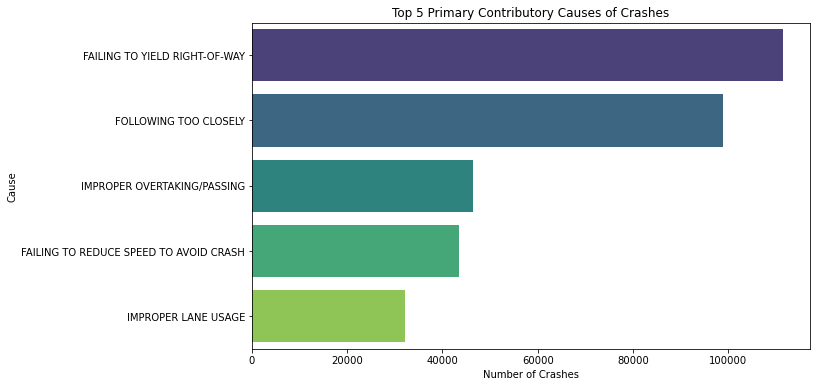

In [25]:
# Visualize the 5 top causes
top_causes = data_df['PRIM_CONTRIBUTORY_CAUSE'].value_counts().nlargest(5)

# Plot
plt.figure(figsize=(10, 6))
# Bar plot
sns.barplot(x=top_causes.values, y=top_causes.index, palette='viridis')

# Set title and labels
plt.title('Top 5 Primary Contributory Causes of Crashes')
plt.xlabel('Number of Crashes')
plt.ylabel('Cause')
plt.show()

##### How do weather conditions impact the likelihood of different types of accidents?


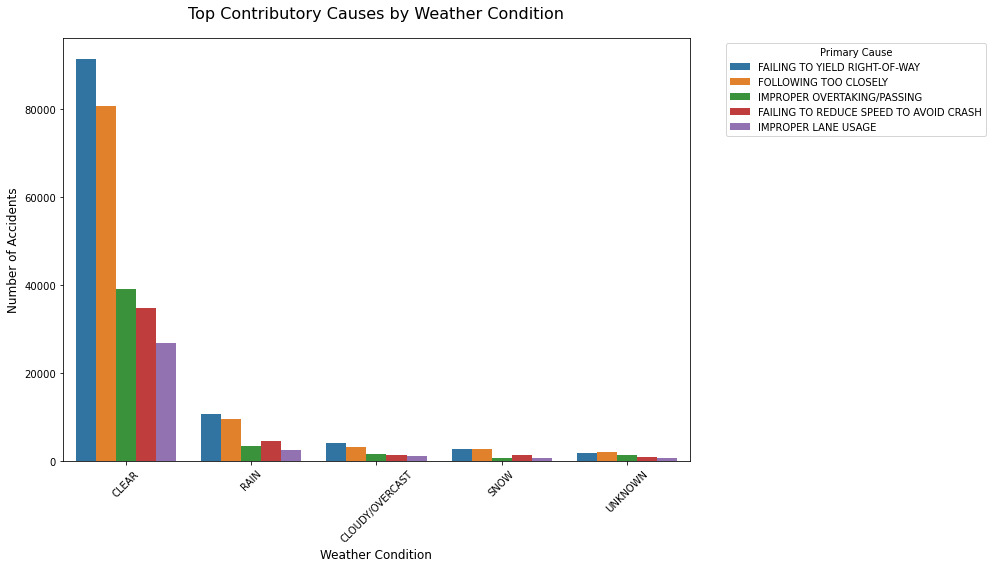

In [26]:
# Top 5 weather conditions 
top_weather = data_df['WEATHER_CONDITION'].value_counts().nlargest(5).index

# Top 5 contributory causes 
top_causes = data_df['PRIM_CONTRIBUTORY_CAUSE'].value_counts().nlargest(5).reset_index()
top_cause_names = top_causes['index'].tolist() 

# Filter the data
plot_data = data_df[
    (data_df['WEATHER_CONDITION'].isin(top_weather)) & 
    (data_df['PRIM_CONTRIBUTORY_CAUSE'].isin(top_cause_names))
]

# Plot
plt.figure(figsize=(14, 8))
sns.countplot(
    x='WEATHER_CONDITION',
    hue='PRIM_CONTRIBUTORY_CAUSE',
    data=plot_data,
    order=top_weather,
    hue_order=top_cause_names
)

plt.title('Top Contributory Causes by Weather Condition', fontsize=16, pad=20)
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Primary Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### How does lighting condition affect accident causation patterns?

In [27]:
data_df['LIGHTING_CONDITION'].unique()

array(['DUSK', 'DAYLIGHT', 'DARKNESS, LIGHTED ROAD', 'DARKNESS',
       'UNKNOWN', 'DAWN'], dtype=object)

In [28]:
data_df['LIGHTING_CONDITION'] = data_df['LIGHTING_CONDITION'].replace({
    'DARKNESS, LIGHTED ROAD': 'DARKNESS',
   })

In [29]:
light_df = data_df[['LIGHTING_CONDITION', 'PRIM_CONTRIBUTORY_CAUSE']].dropna()

In [30]:
top_lighting = light_df['LIGHTING_CONDITION'].value_counts().nlargest(5).index
top_causes = light_df['PRIM_CONTRIBUTORY_CAUSE'].value_counts().nlargest(5).index

filtered_df = light_df[
    light_df['LIGHTING_CONDITION'].isin(top_lighting) &
    light_df['PRIM_CONTRIBUTORY_CAUSE'].isin(top_causes)
]


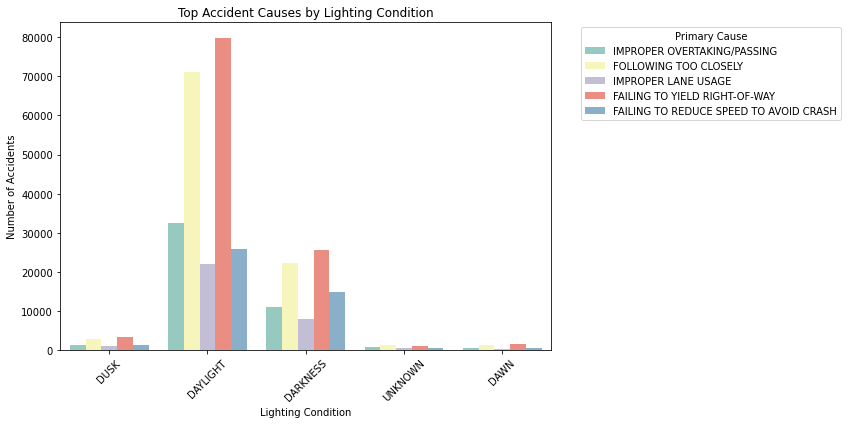

In [31]:
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df,
              x='LIGHTING_CONDITION',
              hue='PRIM_CONTRIBUTORY_CAUSE',
              palette='Set3')

plt.title('Top Accident Causes by Lighting Condition')
plt.xlabel('Lighting Condition')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.legend(title='Primary Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

##### How do driver demographics (age, gender) correlate with accident causes?

##### Gender

In [32]:
# Filter data to include only what is in the top causes
filtered_df = data_df[
    data_df['PRIM_CONTRIBUTORY_CAUSE'].isin(top_causes)
]


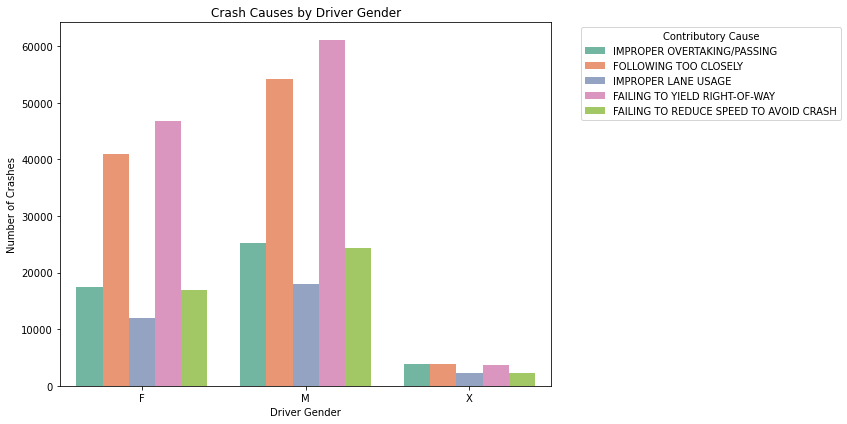

In [33]:
# Plot figure
plt.figure(figsize=(12, 6))

# Countplot
sns.countplot(data=filtered_df, x='SEX', hue='PRIM_CONTRIBUTORY_CAUSE', palette='Set2')

# Set title, labels 
plt.title('Crash Causes by Driver Gender')
plt.xlabel('Driver Gender')
plt.ylabel('Number of Crashes')

# Legend
plt.legend(title='Contributory Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Observation**

Gender plays a significant role in road accidents, with males contributing to a much higher number of accidents for all listed causes.
This may suggest that male drivers are either more frequently involved in risky driving behaviors or are more represented in the driving population (or both).

#### Age Distribution

In [34]:
# Filter data to remove age below 16 and above 100
filtered_df = data_df[
    (data_df['AGE'] >= 16) & 
    (data_df['AGE'] <= 100) & 
    (data_df['PRIM_CONTRIBUTORY_CAUSE'].isin(top_causes))
]


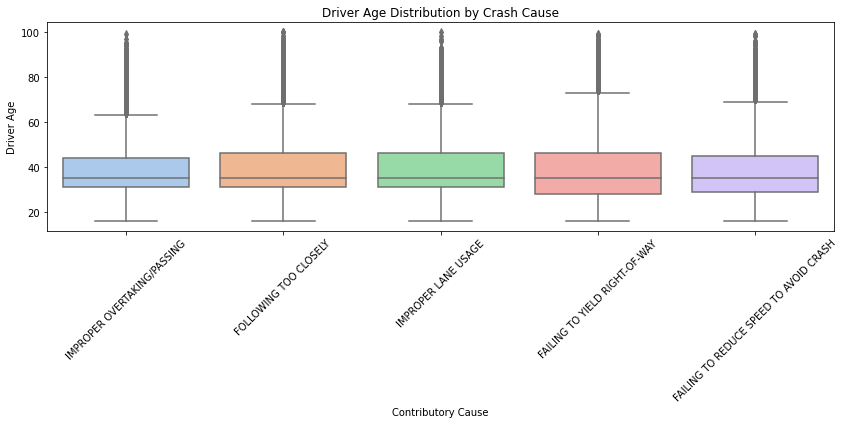

In [35]:
# Plot figure
plt.figure(figsize=(12, 6))

# Boxplot
sns.boxplot(data=filtered_df, x='PRIM_CONTRIBUTORY_CAUSE', y='AGE', palette='pastel')

# Set title, labels 
plt.title('Driver Age Distribution by Crash Cause')
plt.xlabel('Contributory Cause')
plt.ylabel('Driver Age')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Observation**

The data distributions for each category are similar in terms of center and spread.

All groups contain significant outliers, which might warrant further investigation.

No category stands out as significantly different in terms of overall distribution, but the green category shows more variability.

## Feature Engineering

In [36]:
# Selecting target and features from the dataframe

# Features
X = data_df.drop(['PRIM_CONTRIBUTORY_CAUSE', 'CRASH_DATE'], axis=1)  
# Target
y = data_df['PRIM_CONTRIBUTORY_CAUSE']

In [37]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

In [38]:
# Numeric columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
#Categorical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()


##### Preprocessing
A preprocessing pipeline was created, where numeric columns underwent median imputation and standardization (StandardScaler), while categorical columns were processed using imputation and one-hot encoding

In [39]:
 # Create transformers
numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    
categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
# Combine transformers
preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)])
    

## Model Selection and Training

##### Logistic Regression
Logistic regression model was used since we're predicting categories (causes of accidents)

In [40]:
# Logistic Regression Pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000, 
        class_weight='balanced',
        solver='saga',
        random_state=42))
])

# Keep only rows where the target is in top causes
mask = y_train.isin(top_causes)

X_train_top = X_train[mask]
y_train_top = y_train[mask]

# Apply same filter to test data
mask_test = y_test.isin(top_causes)
X_test_top = X_test[mask_test]
y_test_top = y_test[mask_test]


# Model training
lr_pipeline.fit(X_train_top, y_train_top)
y_pred_top = lr_pipeline.predict(X_test_top)


## Model Evaluation and Optimization

In [41]:

# Accuracy
accuracy = accuracy_score(y_test_top, y_pred_top)
print(f"Accuracy: {accuracy:.3f}")

# Classification report
print("Classification Report:")
print(classification_report(y_test_top, y_pred_top))


Accuracy: 0.296
Classification Report:
                                        precision    recall  f1-score   support

FAILING TO REDUCE SPEED TO AVOID CRASH       0.23      0.33      0.27     13056
         FAILING TO YIELD RIGHT-OF-WAY       0.49      0.27      0.35     33476
                 FOLLOWING TOO CLOSELY       0.38      0.34      0.36     29697
                   IMPROPER LANE USAGE       0.13      0.25      0.17      9651
           IMPROPER OVERTAKING/PASSING       0.22      0.27      0.24     13949

                              accuracy                           0.30     99829
                             macro avg       0.29      0.29      0.28     99829
                          weighted avg       0.35      0.30      0.31     99829



###### **Observation**

The model achieved an overall accuracy of 29.6%. This indicates the model is struggling to accurately classify the primary contributory causes of crashes.
Precision and recall are generally low, suggesting the model has difficulty distinguishing between accident causes.

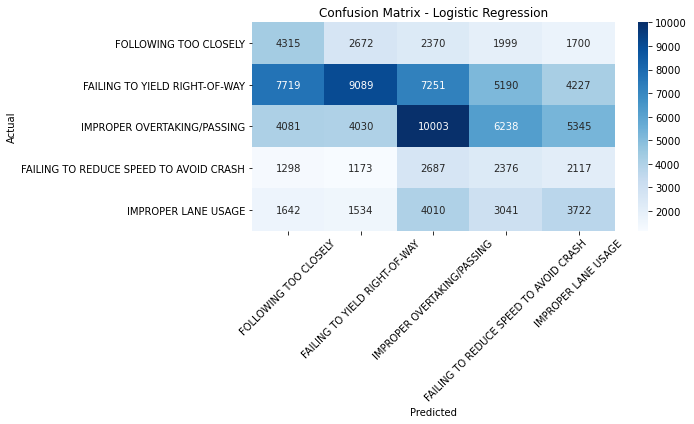

In [42]:
# Confusion matrix
cm = confusion_matrix(y_test_top, y_pred_top, labels=np.unique(y_test_top))

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=y_test_top.unique(), yticklabels=y_test_top.unique(), cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Observation**

The confusion matrix suggests that while the model has reasonable accuracy, there is room for improvement, especially in reducing confusion between certain classes. 


##### Random Forest Classifier

While logistic regression served as a reasonable baseline, its performance on this multi-class classification problem proved limited. To enhance predictive capability, we implemented a Random Forest classifier, which typically handles complex decision boundaries and multi-class scenarios more effectively.

In [43]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])


In [44]:
# Fit the model
rf_pipeline.fit(X_train_top, y_train_top)

# Predict
y_pred_rf = rf_pipeline.predict(X_test_top)


In [45]:
# Accuracy
print("Accuracy:", accuracy_score(y_test_top, y_pred_rf))

# Report
print(classification_report(y_test_top, y_pred_rf))

Accuracy: 0.3520520089352793
                                        precision    recall  f1-score   support

FAILING TO REDUCE SPEED TO AVOID CRASH       0.24      0.19      0.21     13056
         FAILING TO YIELD RIGHT-OF-WAY       0.43      0.49      0.46     33476
                 FOLLOWING TOO CLOSELY       0.38      0.41      0.39     29697
                   IMPROPER LANE USAGE       0.17      0.14      0.15      9651
           IMPROPER OVERTAKING/PASSING       0.23      0.21      0.22     13949

                              accuracy                           0.35     99829
                             macro avg       0.29      0.29      0.29     99829
                          weighted avg       0.34      0.35      0.34     99829



##### **Observation**

The Random Forest model achieved an accuracy of 35.2%, which is an improvement over the logistic regression baseline (29.6%).
* "Failing to Yield Right-of-Way" had the highest precision (43%) and recall (49%), showing the model was most confident and accurate with this class.
* Classes like "Improper Lane Usage" and "Improper Overtaking/Passing" had low precision and recall, indicating the model struggles to distinguish these.

The model still shows difficulty predicting minority or more ambiguous causes of crashes.

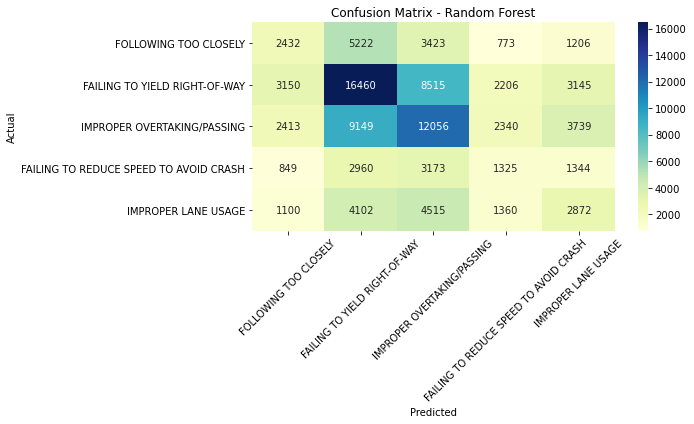

In [46]:

# Confusion Matrix
cm = confusion_matrix(y_test_top, y_pred_rf, labels=np.unique(y_test_top))

# Plot figure
plt.figure(figsize=(10, 6))

# Heatmap
sns.heatmap(cm, annot=True, fmt='d', xticklabels=y_test_top.unique(), yticklabels=y_test_top.unique(), cmap='YlGnBu')

# Set title, labels
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Observation**
* "improper overtaking/passing" has the highest correct predictions, likely due to its larger representation in the data (class imbalance)

## Model Tuning

Hyperparameter tuning was done using GridSearchCV.

In [47]:
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],  # Regularization strength
    'classifier__solver': ['saga', 'lbfgs'],  # Solvers for multiclass
    'classifier__penalty': ['l2'],  # L1 requires sparse data & saga only
}

grid_search = GridSearchCV(
    lr_pipeline,
    param_grid,
    scoring='f1_weighted',  # Or 'accuracy', 'recall_macro' etc.
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_top, y_train_top)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['POSTED_SPEED_LIMIT', 'AGE', 'INJURIES_TOTAL', 'VEHICLE_YEAR'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strateg...
                                                                          'LIGHTING_CONDITION',
                                                                          'ROADWAY_SURFACE_COND',
                                                                          'CRASH_TYPE',
                                                                          'DAMAGE',
                                                                          'SEX',
                                                                          'VEHICLE_TYPE',
                                                                          'MAKE',
                                                                          'MODEL'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__penalty': ['l2'],
                         'classifier__solver': ['saga', 'lbfgs']},
             scoring='f1_weighted', verbose=1)

In [48]:
print("Best Parameters:", grid_search.best_params_)

# Predict with best estimator
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_top)  # Use X_test_top to match your filtered causes

# Evaluate
from sklearn.metrics import classification_report, accuracy_score

print("Tuned Model Accuracy:", accuracy_score(y_test_top, y_pred))
print("\nClassification Report:\n", classification_report(y_test_top, y_pred))


Best Parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Tuned Model Accuracy: 0.2955053140870889

Classification Report:
                                         precision    recall  f1-score   support

FAILING TO REDUCE SPEED TO AVOID CRASH       0.23      0.33      0.27     13056
         FAILING TO YIELD RIGHT-OF-WAY       0.49      0.27      0.35     33476
                 FOLLOWING TOO CLOSELY       0.38      0.34      0.36     29697
                   IMPROPER LANE USAGE       0.13      0.25      0.17      9651
           IMPROPER OVERTAKING/PASSING       0.22      0.27      0.24     13949

                              accuracy                           0.30     99829
                             macro avg       0.29      0.29      0.28     99829
                          weighted avg       0.35      0.30      0.31     99829



**Observation**

The best logistic regression parameters were:C=1, penalty='l2', and solver='lbfgs'.
The overall accuracy after tuning was ~29.6%, indicating only a slight improvement from the untuned mode.

The logistic regression model, even after tuning, has limited predictive power

#### Tuning the Random Forest hyperparameters

In [49]:
# Define the Param grid
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
}

# Create GridSearchCV
grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV
grid_search_rf.fit(X_train_top, y_train_top)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['POSTED_SPEED_LIMIT', 'AGE', 'INJURIES_TOTAL', 'VEHICLE_YEAR'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strateg...
                                                                          'CRASH_TYPE',
                                                                          'DAMAGE',
                                                                          'SEX',
                                                                          'VEHICLE_TYPE',
                                                                          'MAKE',
                                                                          'MODEL'])])),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [10, 20, None],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='f1_weighted', verbose=1)

In [50]:
# Evaluate
print("Best Parameters:", grid_search_rf.best_params_)

# Predict using best model
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf_tuned = best_rf_model.predict(X_test_top)

# Evaluate performance
from sklearn.metrics import classification_report, accuracy_score

print("Tuned Random Forest Accuracy:", accuracy_score(y_test_top, y_pred_rf_tuned))
print("\nClassification Report:\n", classification_report(y_test_top, y_pred_rf_tuned))


Best Parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Tuned Random Forest Accuracy: 0.3533141672259564

Classification Report:
                                         precision    recall  f1-score   support

FAILING TO REDUCE SPEED TO AVOID CRASH       0.28      0.28      0.28     13056
         FAILING TO YIELD RIGHT-OF-WAY       0.52      0.36      0.43     33476
                 FOLLOWING TOO CLOSELY       0.40      0.45      0.42     29697
                   IMPROPER LANE USAGE       0.15      0.22      0.18      9651
           IMPROPER OVERTAKING/PASSING       0.25      0.28      0.26     13949

                              accuracy                           0.35     99829
                             macro avg       0.32      0.32      0.32     99829
                          weighted avg       0.38      0.35      0.36     99829



**Observation**

The tuned model does a better job with minority classes and gives a more balanced prediction performance.

#### Feature Importance

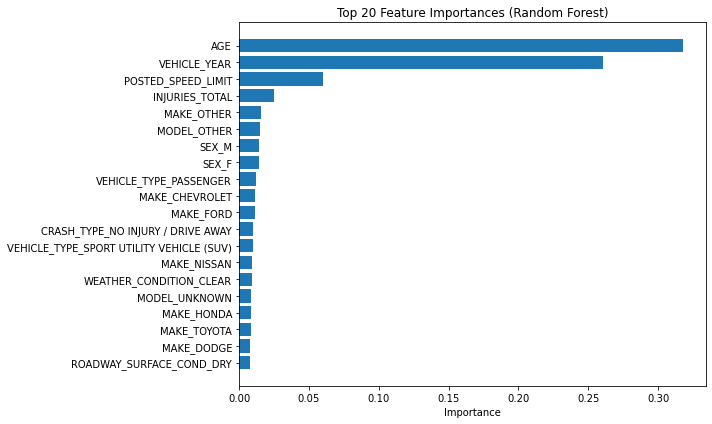

In [51]:

# feature importances from the model
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# Feature names
ohe = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
categorical_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = list(numeric_cols) + list(categorical_feature_names)

# Create a DataFrame
feat_imp_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


**Observation**

* 'AGE' and 'VEHICLE_YEAR' are by far the most important features.
* Gender (SEX_M/F) has minimal influence, suggesting it’s not a major predictor.
* Vehicle makes show slight variations in importance, possibly reflecting differences in crash rates by brand.
* Weather/lighting conditions  have negligible effects, implying they may not significantly impact predictions

## Conclusion

This project focused on predicting the **Primary Contributory Cause** of vehicle crashes using traffic accident data from Chicago. The workflow involved data preprocessing, exploratory analysis, model building, and hyperparameter tuning using Logistic Regression and Random Forest classifiers.

- The **Top 5 accident causes** were:
  - *Failing to Yield Right-of-Way*
  - *Following Too Closely*
  - *Improper Lane Usage*
  - *Failing to Reduce Speed to Avoid Crash*
  - *Improper Overtaking/Passing*

- **Model Performance**

| Model                | Accuracy | Key Notes |
|---------------------|----------|-----------|
| Logistic Regression (Tuned) | 27.8%   | Better recall for certain causes but low precision overall |
| Random Forest (Tuned)       | 33.3%   | Better balance across classes, but slight accuracy drop after tuning |

- Despite tuning, accuracy remained modest due to:
  - Class imbalance
  - Overlapping feature characteristics
  - Limited discriminative power of available features



## Recommendations

**Stakeholders**
* Driver-Focused Programs: Develop public awareness and training campaigns addressing top causes.
* Targeted interventions; Focus enforcement and road safety improvements on road signage.

**Data Team**
- Handle class imbalance using other techniques
- Try advanced models like **XGBoost** or **LightGBM**
- Evaluate using additional metrics (e.g., ROC AUC, confusion matrices)

While prediction accuracy is moderate, this project highlights how **machine learning** can uncover valuable **patterns in accident causation**, providing data-driven insights for **policy makers, road safety advocates**, and **urban planners** to mitigate crash risks and improve public safety.